In [5]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
import seaborn as sb
import deepdish as dd
import seaborn as sns

seed = 42
np.random.seed(seed=seed)


data_setting = 'stftflt'

splitting = 'custom'
if data_setting.startswith('raw'):
    model_setting = 'conv1d'
else:
    model_setting = 'DenseNet121'

### data collecting

In [6]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    12357
2     4029
0     2958
dtype: int64

val: 
1    4144
2    1350
0     954
dtype: int64

test: 
1    12323
2     1745
0     1518
dtype: int64


## Loading model

In [7]:
TL = True

if TL:
    data = Dataset('Wingbeats')
    print(data.target_classes)

    dataset = data
    splitting='random'
    modelname = f'{TEMP_DATADIR}/Flies_TL_{data_setting}_{model_setting}_{splitting}.h5'

    flag = ''
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
    using_conv2d = False
    base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
    base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     base_model.load_weights(traincf.top_weights_path)

    if data_setting == 'rawflt':
        model = Sequential()
        for layer in base_model.layers[:-1]: # go through until last layer
            model.add(layer)
        #     print(layer.trainable)
        model.add(Dense(3, activation='softmax'))
    elif data_setting == 'stftflt':
        base_output = base_model.layers[-2].output
        new_output = Dense(3, activation="softmax")(base_output)
        model = Model(inputs=base_model.inputs, outputs=new_output)
else:
    
    splitting = 'custom'
    modelname = f'{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5'
    
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3).config
model.load_weights(modelname)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pred = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
############ INPUT SHAPE:(129, 120, 1)


0.87


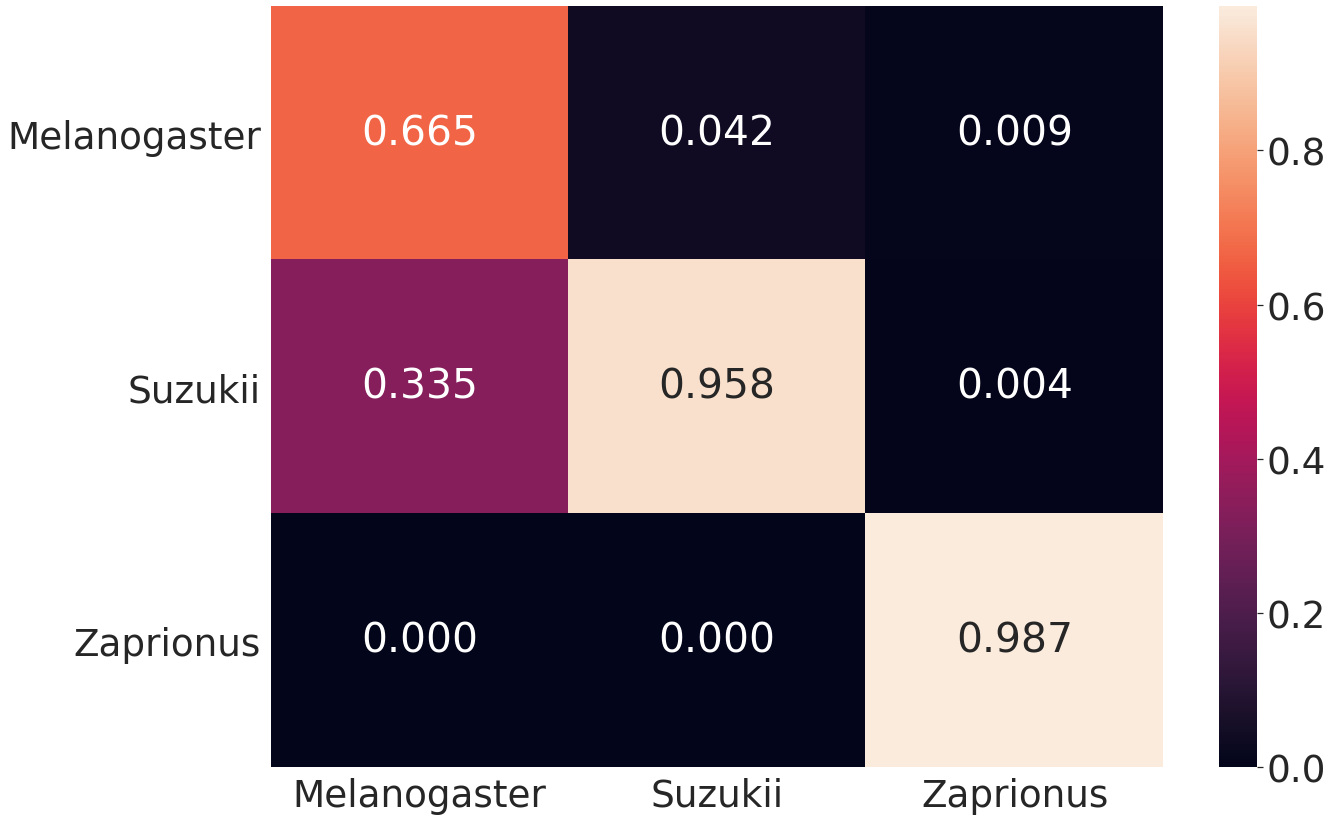

In [8]:
y_pred=np.argmax(pred, axis=1)

mapping = {0:'Melanogaster', 1: 'Suzukii', 2: 'Zaprionus'}

k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

mapping_ar = np.zeros(k.max()+1,dtype=v.dtype) #k,v from approach #1
mapping_ar[k] = v
y_test_mapped = mapping_ar[y_test]
y_pred_mapped = mapping_ar[y_pred]
ba = balanced_accuracy_score(y_true=y_test_mapped, y_pred=y_pred_mapped)
print(f"{ba:.2f}")
cm = confusion_matrix(y_true=y_test_mapped, y_pred=y_pred_mapped,normalize='pred')

sns.set(font_scale=3.4)
plt.figure(figsize=(20,14))
lbls = np.unique(y_test_mapped)
sns.heatmap(cm, annot=True, fmt='.3f', xticklabels=lbls, yticklabels=lbls)
plt.yticks(rotation=0)
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}.png', format='png', bbox_inches='tight')

array([1, 1, 1, ..., 0, 0, 0])